# Location scale regression with smooth covariates 

In [10]:
import jax
import jax.numpy as jnp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
import os 

# Set path such that interpreter finds tigerpy
sys.path.append(os.path.join(os.getcwd(), ".."))

import tigerpy.model as tiger
import tigerpy.bbvi as bbvi
from tigerpy.distributions import MultivariateNormalDegenerate

# We use distributions and bijectors from tensorflow probability
import tensorflow_probability.substrates.jax.distributions as tfjd
import tensorflow_probability.substrates.jax.bijectors as tfjb

rng = np.random.default_rng(42)

# Load the data
df = pd.read_csv('../data/dbbmi.csv', sep=',')

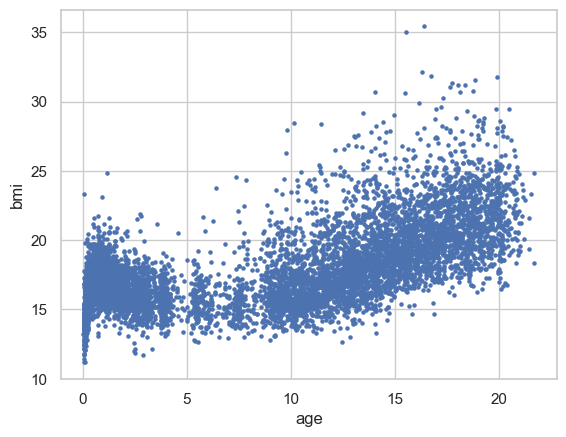

In [11]:
# Plot the data
sns.set_theme(style="whitegrid")
df.plot(kind = "scatter", x = "age", y = "bmi", s = 5)
plt.show()

In [12]:
# Define a model with intercept 
# Set up design matrix for loc
X = tiger.Obs(name="X_loc", intercept=True)
X.smooth(data=df["age"].to_numpy(), n_knots=30)
# If we combine fixed covariates and smooth covariates we need to center the the smooth effects first 
X.center()

# Set up design matrix for scale 
Z = tiger.Obs(name="Z_scale", intercept=True)
Z.smooth(data=df["age"].to_numpy(), n_knots=30)
# If we combine fixed covariates and smooth covariates we need to center the the smooth effects first 
Z.center()

# Linear Predictor for the location ----
# Fixed coefficents 
# Set up beta_fixed hyperparameters 
beta_fixed_loc = tiger.Hyper(0.0, name="beta_fixed_loc")
beta_fixed_scale = tiger.Hyper(100.0, name="beta_fixed_scale")

# Set up parameters
beta_fixed_dist = tiger.Dist(tfjd.Normal, loc=beta_fixed_loc, scale=beta_fixed_scale)
beta_fixed = tiger.Param(value=df["bmi"].to_numpy().mean(), distribution=beta_fixed_dist, name="beta_fixed")

# Smooth coefficients
# Set up hyperparameters for the beta_smooth_scale  
tau_a = tiger.Hyper(1.0, name="tau_a")
tau_b = tiger.Hyper(0.00005, name="tau_b")
tau_dist = tiger.Dist(tfjd.InverseGamma, concentration=tau_a, scale=tau_b)
tau = tiger.Param(value=jnp.array([1.0]), distribution=tau_dist, param_space="positive", name="tau")

# Set up smooth coefficients with mvn degenerate 
# Set up hyperparameters
beta_smooth_loc = tiger.Hyper(np.zeros(X.smooth_dim_cent[0]), name="beta_smooth_loc")

# Set up parameters
beta_smooth_dist = tiger.Dist(MultivariateNormalDegenerate, loc=beta_smooth_loc, scale=tau, pen=X.smooth_pen_mat_cent[0])
beta_smooth = tiger.Param(value=np.zeros(X.smooth_dim_cent[0]), distribution=beta_smooth_dist, name="beta_smooth")

# Set up the linear predictor
lpred_loc = tiger.Lpred(obs=X, beta_fixed=beta_fixed, beta_smooth=beta_smooth)

# Linear Predictor for the scale ----
# Fixed coefficents 
# Set up beta_fixed hyperparameters 
gamma_fixed_loc = tiger.Hyper(0.0, name="gamma_fixed_loc")
gamma_fixed_scale = tiger.Hyper(3.0, name="gamma_fixed_scale")

# Set up parameters
gamma_fixed_dist = tiger.Dist(tfjd.Normal, loc=gamma_fixed_loc, scale=gamma_fixed_scale)
gamma_fixed = tiger.Param(value=np.log(df["bmi"].to_numpy().std()), distribution=gamma_fixed_dist, name="gamma_fixed")

# Smooth coefficients
# Set up hyperparameters for the beta_smooth_scale  
eta_a = tiger.Hyper(1.0, name="eta_a")
eta_b = tiger.Hyper(0.00005, name="eta_b")
eta_dist = tiger.Dist(tfjd.InverseGamma, concentration=eta_a, scale=eta_b)
eta = tiger.Param(value=jnp.array([1.0]), distribution=eta_dist, param_space="positive", name="eta")

# Set up smooth coefficients with mvn degenerate 
# Set up hyperparameters
gamma_smooth_loc = tiger.Hyper(np.zeros(Z.smooth_dim_cent[0]), name="gamma_smooth_loc")

# Set up parameters
gamma_smooth_dist = tiger.Dist(MultivariateNormalDegenerate, loc=gamma_smooth_loc, scale=eta, pen=Z.smooth_pen_mat_cent[0])
gamma_smooth = tiger.Param(value=np.zeros(Z.smooth_dim_cent[0]), distribution=gamma_smooth_dist, name="gamma_smooth")

# ----
# Set up the linear predictor
lpred_scale = tiger.Lpred(obs=Z, gamma_fixed=gamma_fixed, gamma_smooth=gamma_smooth, function=jnp.exp)

# Set up response distribution
response_dist = tiger.Dist(tfjd.Normal, loc=lpred_loc, scale=lpred_scale)
m = tiger.Model(response=df["bmi"].to_numpy(), distribution=response_dist)

## Test log-prob and setup the graph 

In [13]:
m.log_prob

Array(-18207.262, dtype=float32)

In [14]:
m.log_prior

Array(-73.367355, dtype=float32)

In [15]:
graph = tiger.ModelGraph(model=m)
graph.build_graph()

In [16]:
graph.collect_logpriors()

Array(-73.36735, dtype=float32)

In [17]:
graph.logprob()

Array(-18207.262, dtype=float32)

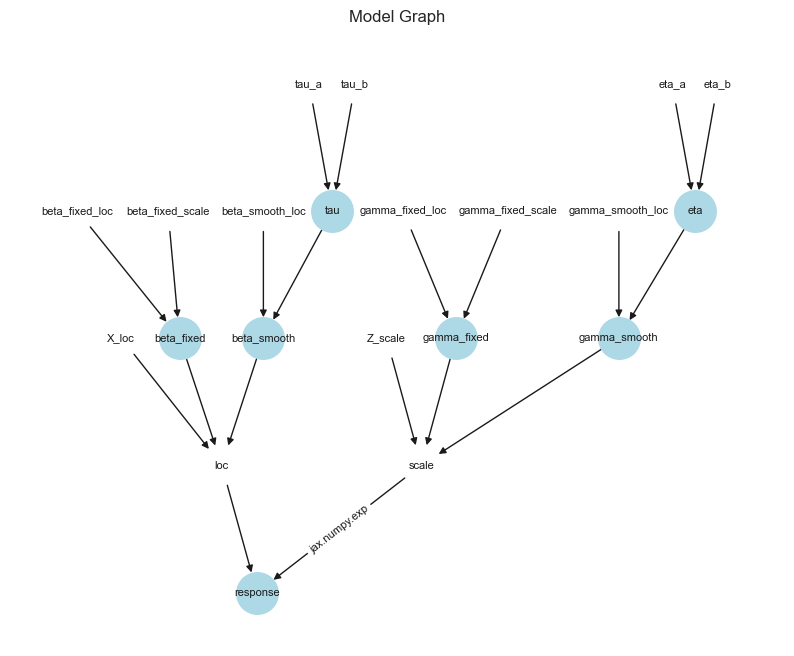

In [9]:
graph.visualize_graph()

## Test where the NA's come from 

In [10]:
import tigerpy.distributions.mvn as mvn
q = bbvi.Bbvi(graph=graph)
key = jax.random.PRNGKey(27)
key, *subkeys = jax.random.split(key, len(q.init_var_params)+1)

In [11]:
# Obtain the variational parameters 
# Parameters location 
loc_beta_fixed, lower_tri_beta_fixed = q.init_var_params["beta_fixed"]["loc"], q.init_var_params["beta_fixed"]["lower_tri"]
loc_beta_smooth, lower_tri_beta_smooth = q.init_var_params["beta_smooth"]["loc"], q.init_var_params["beta_smooth"]["lower_tri"]
loc_tau, lower_tri_tau= q.init_var_params["tau"]["loc"], q.init_var_params["tau"]["lower_tri"]

# Parameters scale
loc_gamma_fixed, lower_tri_gamma_fixed = q.init_var_params["gamma_fixed"]["loc"], q.init_var_params["gamma_fixed"]["lower_tri"]
loc_gamma_smooth, lower_tri_gamma_smooth = q.init_var_params["gamma_smooth"]["loc"], q.init_var_params["gamma_smooth"]["lower_tri"]
loc_eta, lower_tri_eta = q.init_var_params["eta"]["loc"], q.init_var_params["eta"]["lower_tri"]


In [12]:
# Obtain samples from the variational distributions
# Parameters location
samples_beta_fixed = mvn.mvn_precision_chol_sample(loc=loc_beta_fixed, precision_matrix_chol=lower_tri_beta_fixed, key=subkeys[0], S=64)
samples_beta_smooth = mvn.mvn_precision_chol_sample(loc=loc_beta_smooth, precision_matrix_chol=lower_tri_beta_smooth, key=subkeys[1], S=64)
samples_tau = mvn.mvn_precision_chol_sample(loc=loc_tau, precision_matrix_chol=lower_tri_tau, key=subkeys[2], S=64)

# Parameters scale 
samples_gamma_fixed = mvn.mvn_precision_chol_sample(loc=loc_gamma_fixed, precision_matrix_chol=lower_tri_gamma_fixed, key=subkeys[3], S=64)
samples_gamma_smooth = mvn.mvn_precision_chol_sample(loc=loc_gamma_smooth, precision_matrix_chol=lower_tri_gamma_smooth, key=subkeys[4], S=64)
samples_eta = mvn.mvn_precision_chol_sample(loc=loc_eta, precision_matrix_chol=lower_tri_eta, key=subkeys[5], S=64)

In [13]:
# Store all the variational samples in a dict
test_samples = {"beta_fixed": samples_beta_fixed,
                "beta_smooth": samples_beta_smooth,
                "tau": jnp.exp(samples_tau),
                "gamma_fixed": samples_gamma_fixed,
                "gamma_smooth": samples_gamma_smooth,
                "eta": jnp.exp(samples_eta)}

In [14]:
jnp.log(df["bmi"].to_numpy().std())

Array(1.0671998, dtype=float32)

In [15]:
for kw, value in test_samples.items():
    print(jnp.mean(value, axis=0))

[18.250137]
[ 0.18041912 -0.17759414 -0.01105324  0.04873802 -0.01233988  0.16652505
  0.15328854  0.27443665  0.14211816  0.00464203  0.1563411  -0.04232728
  0.01314852 -0.2597431   0.04689287 -0.1501235   0.19508782 -0.06865343
 -0.0133689 ]
[1.0155115]
[1.0493159]
[-0.00586101  0.00469897  0.00043366 -0.00992262  0.01726486 -0.00430268
  0.00614567  0.00403654  0.01019055 -0.01270801  0.00346192 -0.00253064
  0.02954823  0.00498628  0.003747    0.02283442  0.00731117 -0.00514648
 -0.013905  ]
[1.0045741]


In [16]:
batch_idx = jax.random.choice(key, q.num_obs, (32,), replace=False)

In [17]:
data_new = jax.tree_map(lambda x: x[batch_idx], q.data)

In [18]:
graph.logprob()

Array(-18183.508, dtype=float32)

In [19]:
graph.collect_logpriors()

Array(-49.613407, dtype=float32)

In [20]:
q.mc_logprob(data_new,  test_samples, q.num_obs)

Array(-19381.422, dtype=float32)

In [21]:
-2.3446405e+06

-2344640.5

In [22]:
q.lower_bound(q.init_var_params, 
              data_new,
              num_obs=q.num_obs,
              num_var_samples=64,
              key=key)

Array(19444.531, dtype=float32)

## Inference with Bbvi

In [117]:
q = bbvi.Bbvi(graph=graph)

In [118]:
q.num_var_params

936

In [119]:
q.run_bbvi(step_size=0.01,
           threshold=1e-2,
           key_int=1,
           batch_size=256,
           num_var_samples=32,
           chunk_size=50,
           epochs=1000)

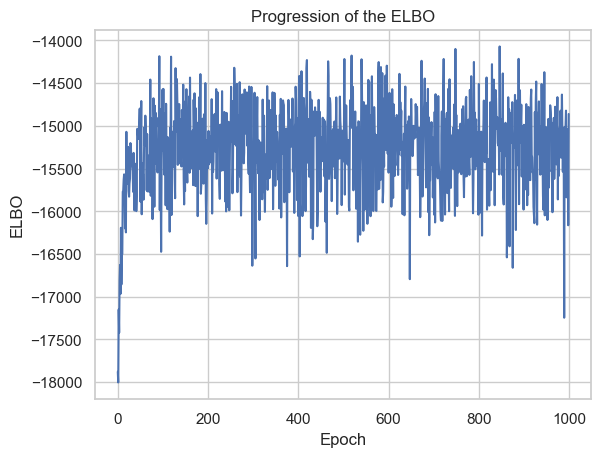

In [120]:
q.plot_elbo()

## Visualize the regression line 

In [121]:
b = q.trans_var_params["beta_smooth"]["loc"]

In [122]:
g = q.trans_var_params["gamma_smooth"]["loc"]

In [123]:
# Location
# for fixed and smooth terms
b_fixed = q.trans_var_params["beta_fixed"]["loc"]
b_smooth = q.trans_var_params["beta_smooth"]["loc"]
b = jnp.concatenate((b_fixed, b_smooth))
y_loc = X.design_matrix @ b
# Scale 
g_fixed = q.trans_var_params["gamma_fixed"]["loc"]
g_smooth = q.trans_var_params["gamma_smooth"]["loc"]
g = jnp.concatenate((g_fixed, g_smooth))
y_scale = jnp.exp(Z.design_matrix @ g)


In [124]:
y_scale

Array([1.3604374, 1.3599533, 1.3599533, ..., 2.5317945, 2.5372992,
       2.5382447], dtype=float32)

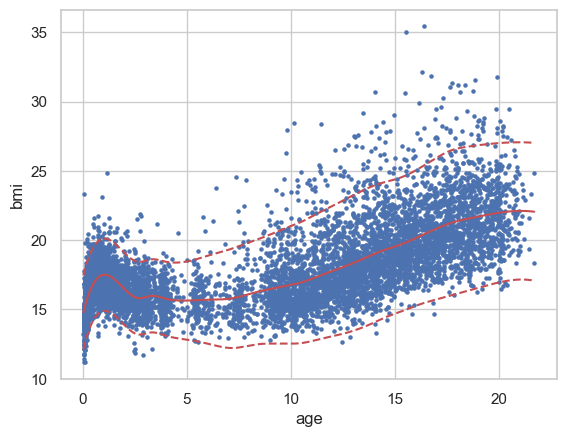

In [126]:
# plot the data
fig, ax = plt.subplots()

df.plot(kind="scatter", x="age", y="bmi", s=5, ax=ax)
ax.plot(df["age"].to_numpy(), y_loc, color = "r")
ax.plot(df["age"].to_numpy(), y_loc - 1.96*y_scale, color = "r", linestyle="--")
ax.plot(df["age"].to_numpy(), y_loc + 1.96*y_scale, color = "r", linestyle="--")
plt.show()

In [131]:
tau = q.trans_var_params["tau"]["loc"]
tau_s = q.trans_var_params["tau"]["cov"]
eta = q.trans_var_params["eta"]["loc"]
eta_s = q.trans_var_params["eta"]["cov"]

In [134]:
m1 = jnp.exp(tau + tau_s/2)
m2 = jnp.exp(eta + eta_s/2)

In [133]:
1 / (m1 ** 2)

Array([[4.6005764]], dtype=float32)

In [135]:
1 / (m2 ** 2)

Array([[501.51675]], dtype=float32)